# Regression (Linear and Logistic) and LDA using TensorFlow
BITS F464 Assigment 3

### Data Preprocessing

In [761]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [762]:
df=pd.read_csv('./data/coa_data.csv')
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [763]:
df.shape

(500, 9)

In [764]:
df.describe()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,250.500000,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,144.481833,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,125.750000,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,250.500000,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,375.250000,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,500.000000,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


In [765]:
df.isnull().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

In [766]:
df.isna().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

In [767]:
df.nunique()

Serial No.           500
GRE Score             49
TOEFL Score           29
University Rating      5
SOP                    9
LOR                    9
CGPA                 184
Research               2
Chance of Admit       61
dtype: int64

Since serial no is unique to each row, it won't contribute anything to the model's learning.
Thus, we drop it.

In [768]:
df.drop(['Serial No.'], axis=1, inplace=True)

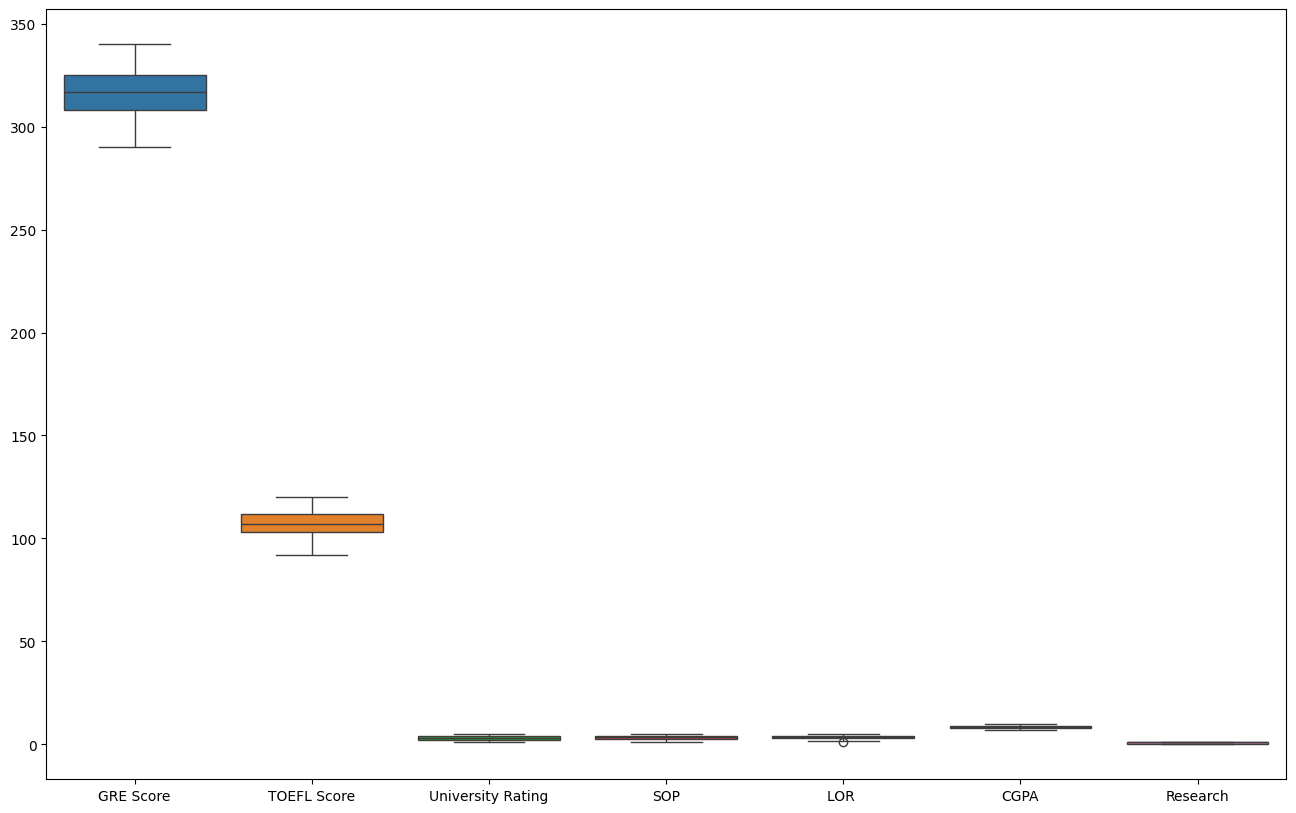

Number of outliers per attribute: 
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  1
CGPA                 0
Research             0
dtype: int64


In [769]:
def outlier_handling(df,target):
    df_new = df.copy()
    df_new.drop([target], axis=1, inplace=True)
    plt.figure(figsize=(16, 10))
    sns.boxplot(data=df_new)
    plt.show()
    Q1 = df_new.quantile(0.25)
    Q3 = df_new.quantile(0.75)
    IQR = Q3 - Q1
    outliers = (df_new < (Q1 - 1.5 * IQR)) | (df_new > (Q3 + 1.5 * IQR))
    print("Number of outliers per attribute: \n", outliers.sum(), sep="")
    df = df[~outliers.any(axis=1)]

outlier_handling(df,"Chance of Admit ")

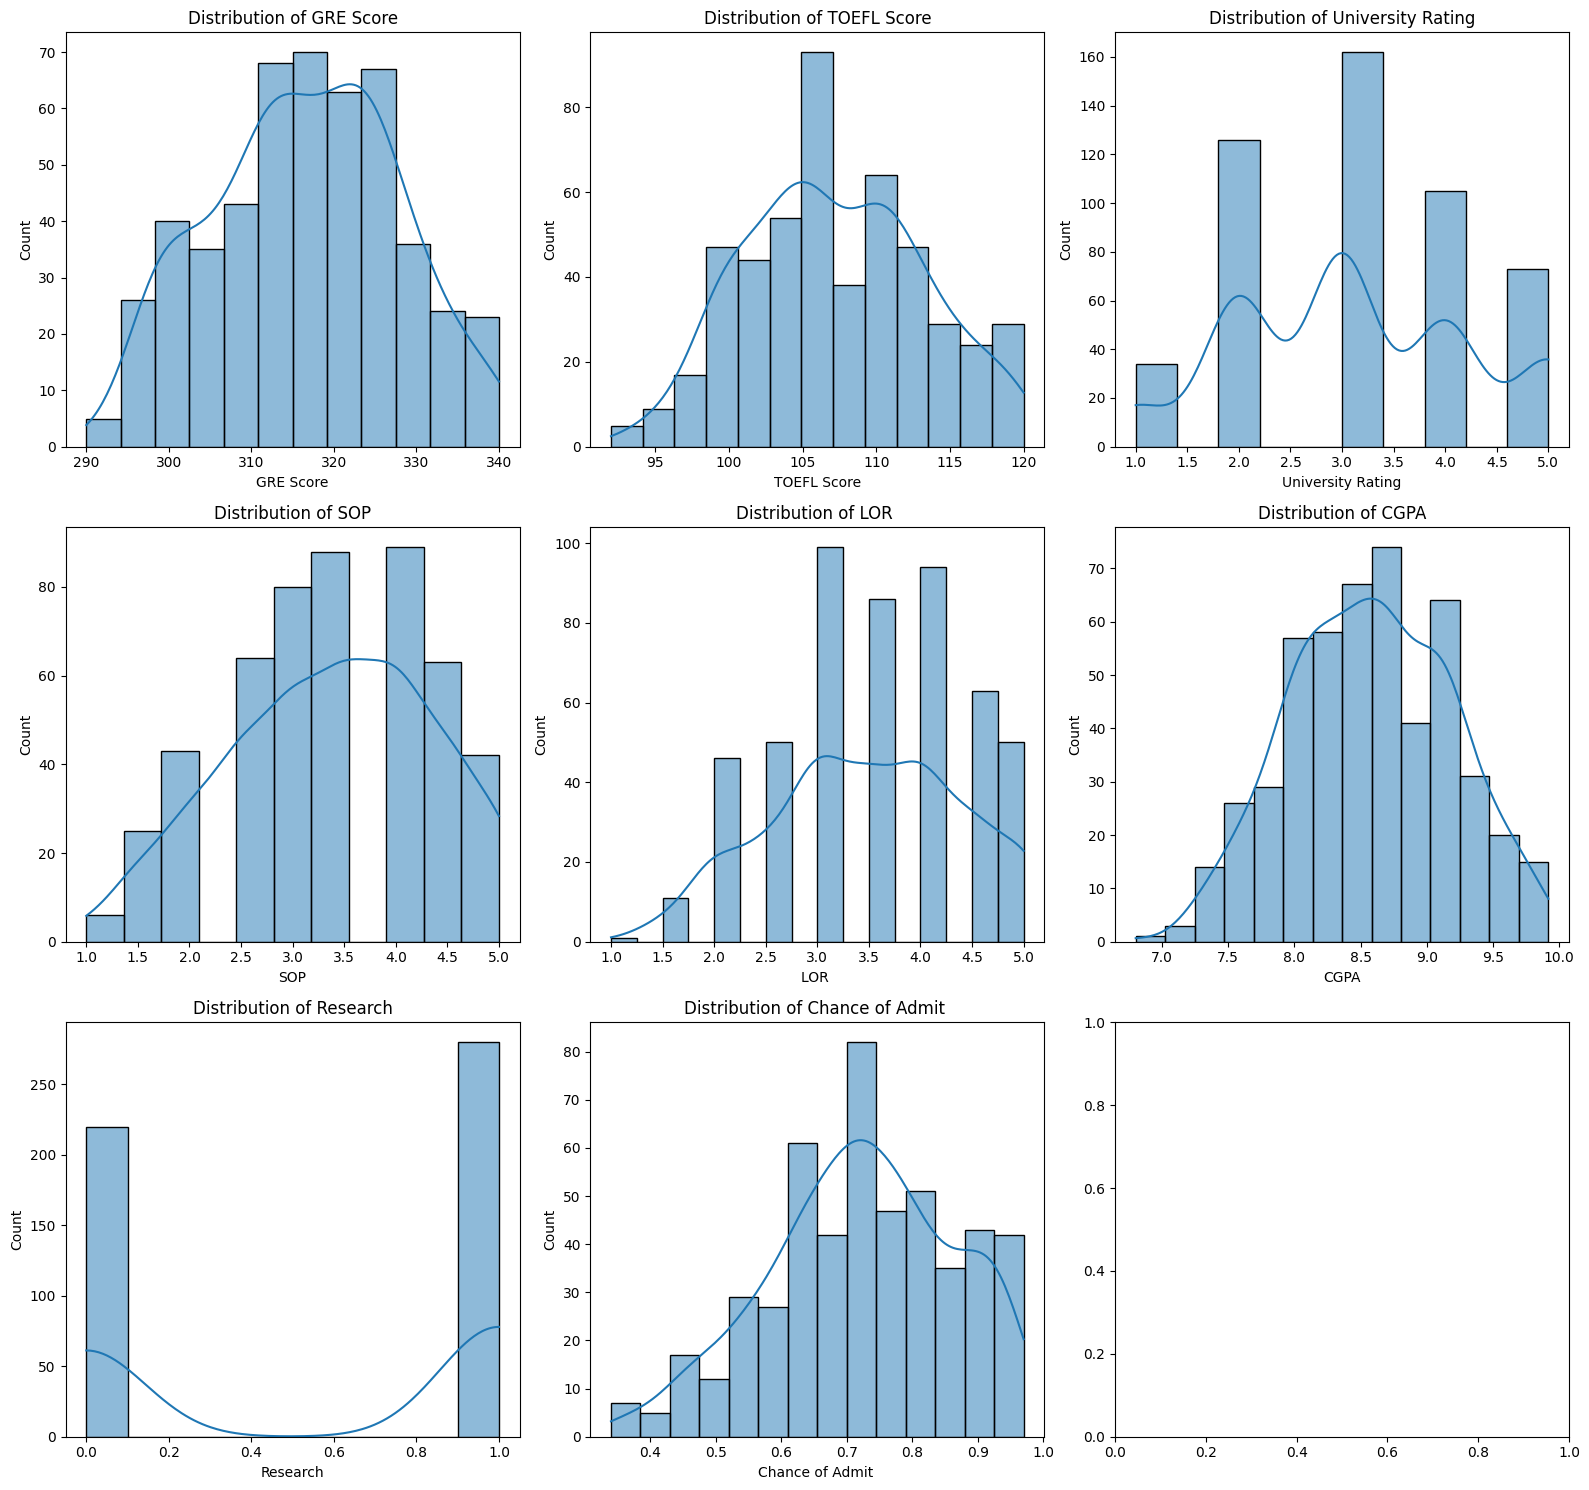

In [770]:
def visualize_numerical(df):
    num_cols = df.select_dtypes(include=['number']).columns
    num_plots = len(num_cols)
    num_rows = (num_plots // 3) + (num_plots % 3 > 0)
    fig, ax = plt.subplots(num_rows, 3, figsize=(16, 5*num_rows))
    for i, feature in enumerate(num_cols):
        row = i // 3
        col = i % 3
        sns.histplot(data=df, x=feature, ax=ax[row, col], kde=True)
        ax[row, col].set_title(f'Distribution of {feature}')
    plt.tight_layout()

visualize_numerical(df)

- We don't have many outlier, thus we won't use RobustScaler.
- Since no feature dominates others due to its range, we won't use MinMaxScaler.
- Since most features are normally distributed, we'll use StandardScaler.

### Data Scaling

In [771]:
from sklearn.preprocessing import StandardScaler

def scaler(df, numerical_features, scaler):
    scaled_df = pd.DataFrame(scaler.fit_transform(df[numerical_features]), columns=numerical_features)
    return scaled_df

y=df['Chance of Admit ']
df.drop(['Chance of Admit '], axis=1, inplace=True)
df=scaler(df,df.select_dtypes(include=[np.number]).columns,StandardScaler())
df['Chance of Admit ']=y

df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1.819238,1.778865,0.775582,1.137360,1.098944,1.776806,0.886405,0.92
1,0.667148,-0.031601,0.775582,0.632315,1.098944,0.485859,0.886405,0.76
2,-0.041830,-0.525364,-0.099793,-0.377773,0.017306,-0.954043,0.886405,0.72
3,0.489904,0.462163,-0.099793,0.127271,-1.064332,0.154847,0.886405,0.80
4,-0.219074,-0.689952,-0.975168,-1.387862,-0.523513,-0.606480,-1.128152,0.65


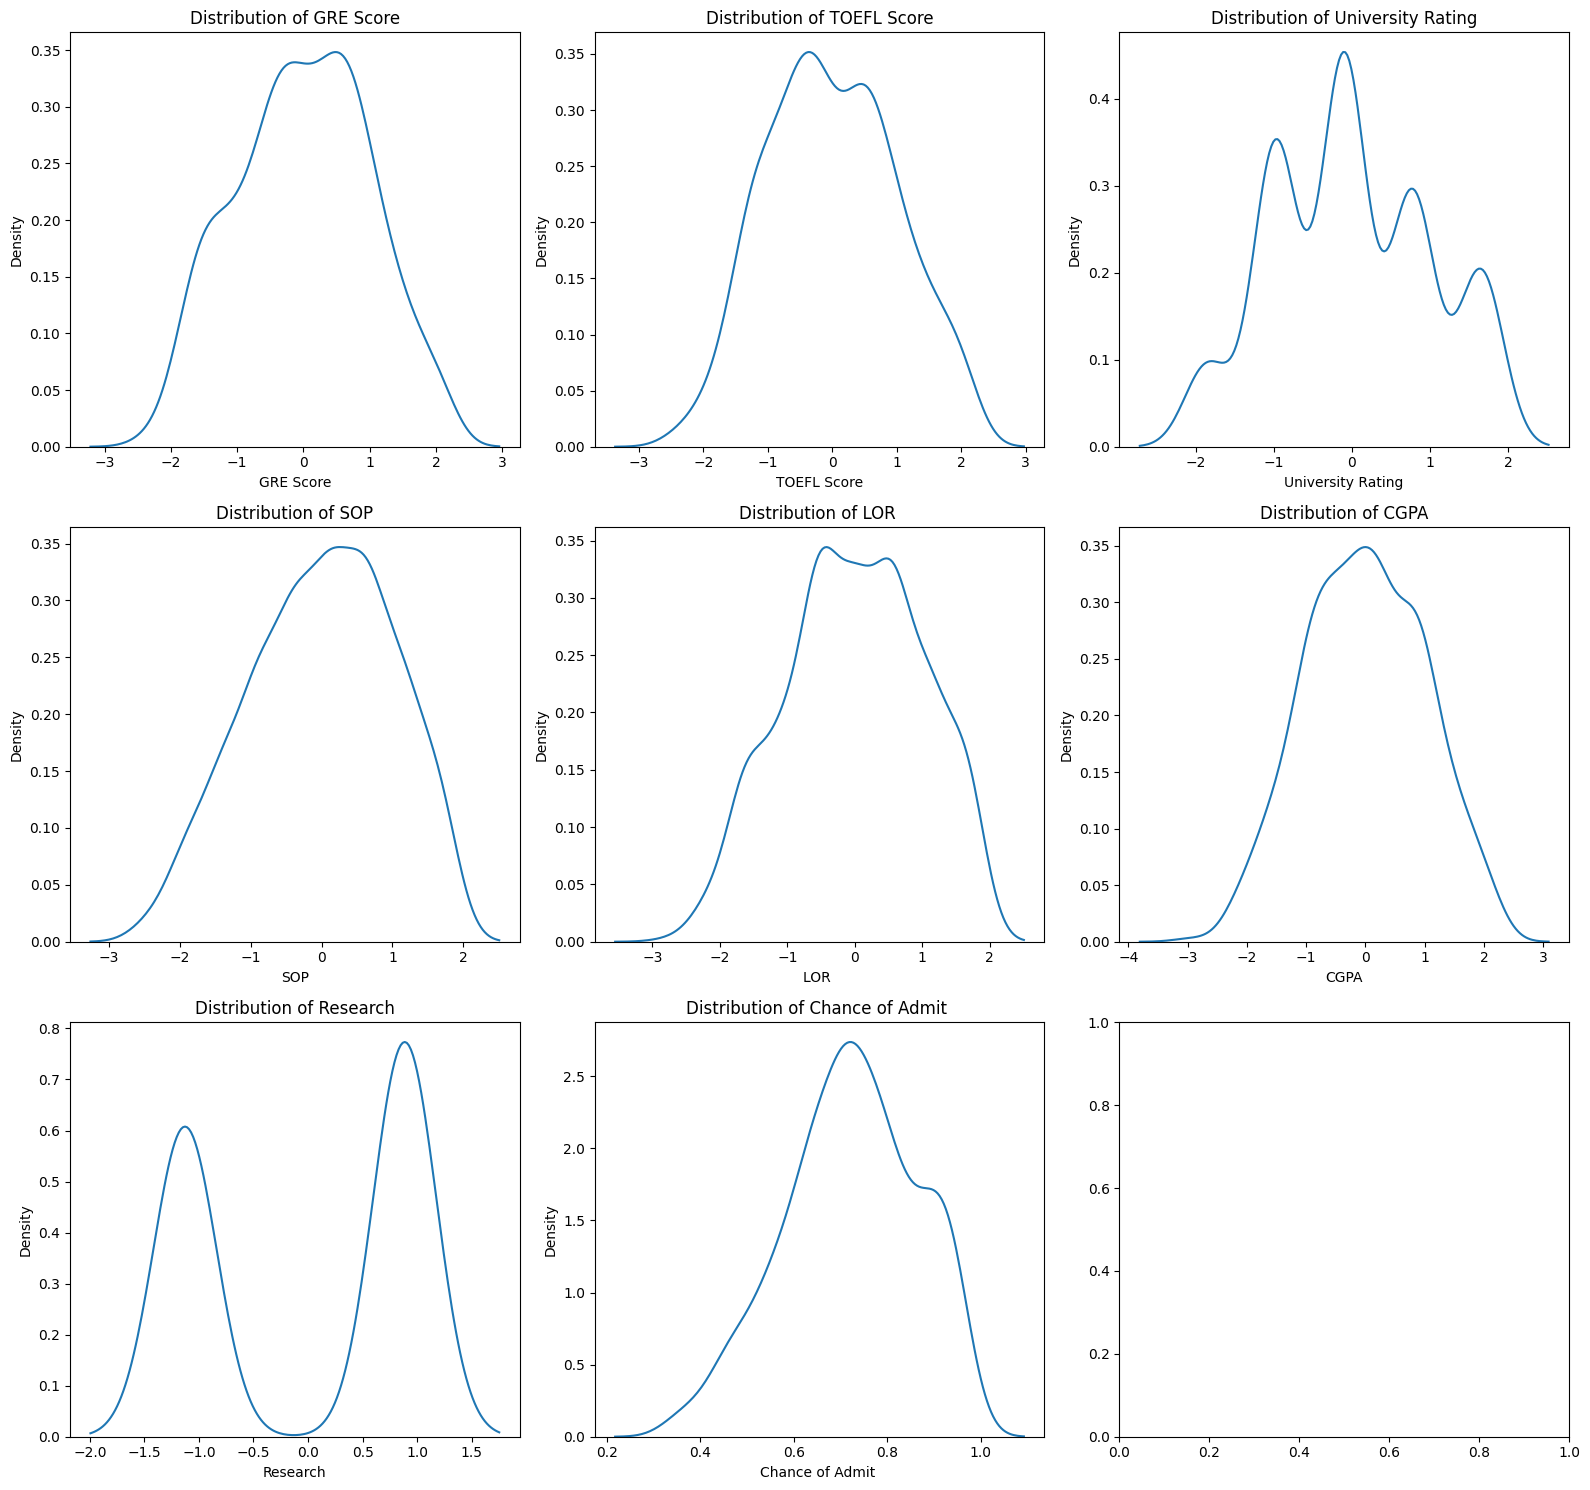

In [772]:
def visualize_kde(df):
    num_cols = df.select_dtypes(include=[np.number]).columns
    num_plots = len(num_cols)
    num_rows = (num_plots // 3) + (num_plots % 3 > 0)
    fig, ax = plt.subplots(num_rows, 3, figsize=(16, 5*num_rows))
    for i, feature in enumerate(num_cols):
        row = i // 3
        col = i % 3
        sns.kdeplot(data=df, x=feature, ax=ax[row, col])
        ax[row, col].set_title(f'Distribution of {feature}')
    plt.tight_layout()

visualize_kde(df)

### Dimensionality Reduction with LDA

In [773]:
df['Chance of Admit '].describe()

count    500.00000
mean       0.72174
std        0.14114
min        0.34000
25%        0.63000
50%        0.72000
75%        0.82000
max        0.97000
Name: Chance of Admit , dtype: float64

In [774]:
bins=[0,0.5,0.75,1]

labels=['Low','Medium','High']
df['Chance of Admit ']=pd.cut(df['Chance of Admit '],bins=bins,labels=labels)

df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1.819238,1.778865,0.775582,1.137360,1.098944,1.776806,0.886405,High
1,0.667148,-0.031601,0.775582,0.632315,1.098944,0.485859,0.886405,High
2,-0.041830,-0.525364,-0.099793,-0.377773,0.017306,-0.954043,0.886405,Medium
3,0.489904,0.462163,-0.099793,0.127271,-1.064332,0.154847,0.886405,High
4,-0.219074,-0.689952,-0.975168,-1.387862,-0.523513,-0.606480,-1.128152,Medium


In [775]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

X=df.drop(['Chance of Admit '],axis=1)
y=df['Chance of Admit ']

lda=LinearDiscriminantAnalysis()
X=lda.fit_transform(X,y)

df=pd.DataFrame(X,columns=['LDA1','LDA2'])
df['Chance of Admit ']=y

df.head()

,LDA1,LDA2,Chance of Admit
0,-3.088197,0.663746,High
1,-1.186912,-0.240582,High
2,0.867028,-0.926579,Medium
3,-0.332192,-1.136026,High
4,1.277001,1.267692,Medium


In [776]:
df.shape

(500, 3)

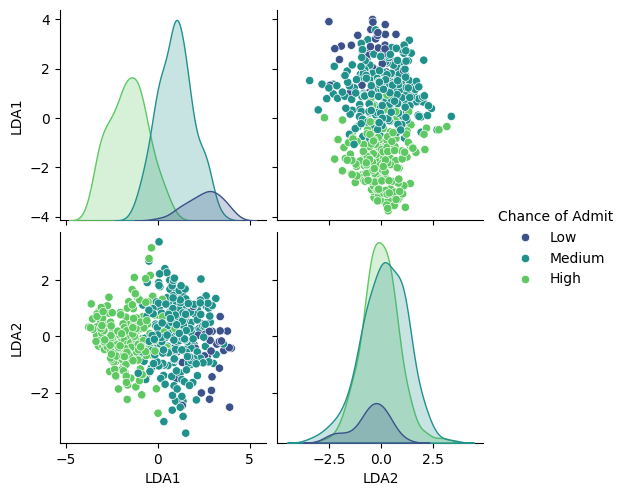

In [777]:
sns.pairplot(data=df,hue='Chance of Admit ',palette='viridis')
plt.show()

LDA Insights:
- TODO